--------------------
## **Context**
--------------------

Hamlet is a classic written by Hamlet...
In this case study, **we will analyze the co-occurrence network of the characters in Shakespeare's Hamlet** 

The dataset is publicly available from Gutenburg Project

**Note: Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books**.

-------------------------
## **Objectives:** 
-------------------------
- Load all the raw datasets and perform descriptive analysis
- Run Network Analysis Algorithms on individual books (and combined)
- Calculate the different centralities measures and provide inference
- Create Network Graphs using Plotly
- Run Louvain Community Detection and find out different groups/communities in the data

In [24]:
%matplotlib inline

import networkx as nx

from decorator import decorator

from networkx.utils import create_random_state, create_py_random_state

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import os

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Update the default background style of the plots
sns.set_style(style='darkgrid')

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

import plotly.graph_objs as go

import plotly

import plotly.express as px
init_notebook_mode(connected=True)

In [4]:
!pip install plotly 
!pip install community 
!pip install python-louvain
!pip install colorlover

# Summary

#### characters

In [5]:
filepath = Path('folder/characters_df.csv') 
characters=pd.read_csv(filepath)
characters.drop(columns=["Unnamed: 0"],inplace=True)
characters.head()

,Alias,Player
0,King.,Claudius
1,Mar.,Marcellus
2,Ham.,Hamlet
3,Pol.,Polonius
4,Hor.,Horatio


#### character_line

In [6]:
filepath = Path('folder/character_line_df.csv') 
character_line=pd.read_csv(filepath)
character_line.head()

,Unnamed: 0,Alias,Player,lines
0,2,Ham.,Hamlet,358
1,0,King.,Claudius,116
2,4,Hor.,Horatio,108
3,3,Pol.,Polonius,86
4,23,Queen.,Getrude,79


#### acts

In [7]:
filepath = Path('folder/acts_df.csv') 
acts=pd.read_csv(filepath)
acts.drop(columns=["Unnamed: 0"],inplace=True)
acts.tail()

,player_lines,Act No.
4408,Exeunt marching; after the which a...,ACT V.
4409,...,ACT V.
4410,\n,ACT V.
4411,\n,ACT V.
4412,THE END\n,ACT V.


#### player_line_act

In [8]:
filepath = Path('folder/line_act_df.csv') 
player_line_act=pd.read_csv(filepath)
player_line_act.drop(columns=["Unnamed: 0"],inplace=True)
player_line_act.head()

,Player,Alias,Act I.,Act II.,Act III.,Act VI.,Act V
0,Claudius,King.,7,16,21,56,16
1,Marcellus,Mar.,32,0,0,0,0
2,Hamlet,Ham.,72,59,105,26,96
3,Polonius,Pol.,9,59,18,0,0
4,Horatio,Hor.,63,0,7,5,33


#### relationship_act

In [25]:
os.listdir("relationship/")

['act5_df.csv',
 'act3_df.csv',
 'act1_df.csv',
 'act4_df.csv',
 '.ipynb_checkpoints',
 'act2_df.csv',
 'act0_df.csv']

In [34]:

relationship_act1=pd.read_csv("relationship/act1_df.csv")
relationship_act1.drop(columns=["Unnamed: 0"],inplace=True)
relationship_act1["Act no."]="Act I."
relationship_act1["Type"]="Undirected"
relationship_act1

relationship_act2=pd.read_csv("relationship/act2_df.csv")
relationship_act2.drop(columns=["Unnamed: 0"],inplace=True)
relationship_act2["Act no."]="Act II."
relationship_act2["Type"]="Undirected"
relationship_act2

relationship_act3=pd.read_csv("relationship/act3_df.csv")
relationship_act3.drop(columns=["Unnamed: 0"],inplace=True)
relationship_act3["Act no."]="Act III."
relationship_act3["Type"]="Undirected"
relationship_act3

relationship_act4=pd.read_csv("relationship/act4_df.csv")
relationship_act4.drop(columns=["Unnamed: 0"],inplace=True)
relationship_act4["Act no."]="Act IV."
relationship_act4["Type"]="Undirected"
relationship_act4

relationship_act5=pd.read_csv("relationship/act5_df.csv")
relationship_act5.drop(columns=["Unnamed: 0"],inplace=True)
relationship_act5["Act no."]="Act V."
relationship_act5["Type"]="Undirected"
relationship_act5.head()

,Person 1,Person 2,weight,Act no.,Type
0,King.,Ham.,20,Act V.,Undirected
1,King.,Hor.,2,Act V.,Undirected
2,King.,Laer.,14,Act V.,Undirected
3,King.,Osr.,5,Act V.,Undirected
4,King.,Queen.,4,Act V.,Undirected


In [36]:
acts=[relationship_act1,relationship_act2,relationship_act3,relationship_act4,relationship_act5]

acts_combined = pd.DataFrame()

for act in acts:
    acts_combined = pd.concat([acts_combined, act])

# Grouping the data by Person 2 and Person 1 to avoid multiple entries with the same characters 
acts_combined = acts_combined.groupby(["Person 2", "Person 1"], as_index = False)["weight"].sum()



# Descriptive Analytics

In [37]:
acts_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Person 2  118 non-null    object
 1   Person 1  118 non-null    object
 2   weight    118 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ KB


In [38]:
acts_combined.describe()

,weight
count,118.00
mean,13.20
std,16.48
min,1.00
25%,2.25
50%,6.50
75%,18.00
max,89.00


**Observations: **

- There are **118 edges** in total, or 118 co-occurrences of characters.
- The **minimum weight is 1** (meaning every co-occurrence pair has been observed at least thrice), and the **maximum weight is 89**.
- The **mean weight is 13.20**, meaning that on average, two co-occurring characters are mentioned around 13 times together. **The median of 6.5** also implies that **it is the maximum weight which is more likely the outlier,** which is also affirmed by the fact that 75% of the weight values are 18 or lower.

In [39]:
acts_combined[acts_combined["weight"] == 89]


,Person 2,Person 1,weight
30,Ham.,Hor.,89


**Observation:**

- The maximum number of 89 connections is shown below to be between **Hamlet and Horatio**, who were pivotal co-characters in Hamlet.

## **Creating a Graph Network (for each act as well as all the acts combined)**

In [41]:
# nx.from_pandas_edgelist returns a graph from a Pandas DataFrame containing an edge list
G1 = nx.from_pandas_edgelist(relationship_act1, 'Person 1', "Person 2", edge_attr = "weight", create_using = nx.Graph())

G2 = nx.from_pandas_edgelist(relationship_act2, 'Person 1', "Person 2", edge_attr = "weight", create_using = nx.Graph())

G3 = nx.from_pandas_edgelist(relationship_act3, 'Person 1', "Person 2", edge_attr = "weight", create_using = nx.Graph())

G4 = nx.from_pandas_edgelist(relationship_act4, 'Person 1', "Person 2", edge_attr = "weight", create_using = nx.Graph())

G5 = nx.from_pandas_edgelist(relationship_act5, 'Person 1', "Person 2", edge_attr = "weight", create_using = nx.Graph())

G = nx.from_pandas_edgelist(acts_combined, 'Person 1', "Person 2", edge_attr = "weight", create_using = nx.Graph())

### **Number of nodes and edges across all books**

In [43]:
nx.info(G)

/var/folders/fc/3zs433w12qd3yx2txjxbbsph0000gn/T/ipykernel_10273/1064119803.py:1: DeprecationWarning:

info is deprecated and will be removed in version 3.0.




'Graph with 22 nodes and 64 edges'

### **Creating functions to calculate the number of unique connections per character, Degree Centrality, Eigenvector Centrality, and Betweenness Centrality**

In [45]:
# The number of unique connections

def numUniqueConnec(G):
    numUniqueConnection = list(G.degree())
    
    numUniqueConnection = sorted(numUniqueConnection, key = lambda x:x[1], reverse = True)
    
    numUniqueConnection = pd.DataFrame.from_dict(numUniqueConnection)
    
    numUniqueConnection.columns = (["Character", "NumberOfUniqueHCPConnections"])
    
    return numUniqueConnection

In [52]:
numUniqueConnec(G)

,Character,NumberOfUniqueHCPConnections
0,Hor.,14
1,Ham.,14
2,Queen.,13
3,King.,11
4,Pol.,9
5,Laer.,8
6,Ros.,7
7,Oph.,7
8,Guil.,6
9,Ber.,5


**Observation:**

- **Hamlet and Horatio** are the characters with the **highest number of unique connections**, followed by Queen and King.

In [53]:
# Degree Centrality 
''' nx.degree_centrality(G) computes the degree centrality for nodes.
The degree centrality for a node v is the fraction of nodes it is connected to.'''

def deg_central(G):
    deg_centrality = nx.degree_centrality(G)
    
    deg_centrality_sort = sorted(deg_centrality.items(), key = lambda x:x[1], reverse = True) #sort the degree centralities of characters in decending order
    
    deg_centrality_sort = pd.DataFrame.from_dict(deg_centrality_sort)
    
    deg_centrality_sort.columns = (["Character", "Degree Centrality"])
    
    return deg_centrality_sort

In [54]:
deg_centrality_sort = deg_central(G)
deg_central(G)

,Character,Degree Centrality
0,Hor.,0.67
1,Ham.,0.67
2,Queen.,0.62
3,King.,0.52
4,Pol.,0.43
5,Laer.,0.38
6,Ros.,0.33
7,Oph.,0.33
8,Guil.,0.29
9,Ber.,0.24


**Observation:**

- **Hamlet and Horatio** are the characters with the **highest number of unique connections**, followed by Queen and King.

The higher the number of connections, the higher the Degree Centrality.

In [55]:
# Eigenvector Centrality
''' nx.eigenvector_centrality computes the eigenvector centrality for the graph G.
Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. 
The eigenvector centrality for node i is the i-th element of the vector x defined by the equation Ax=kx'''

def eigen_central(G):
    eigen_centrality = nx.eigenvector_centrality(G, weight = "weight")
    
    eigen_centrality_sort = sorted(eigen_centrality.items(), key = lambda x:x[1], reverse = True)
    
    eigen_centrality_sort = pd.DataFrame.from_dict(eigen_centrality_sort)
    
    eigen_centrality_sort.columns = (["Character", "EigenVector Centrality"])
    
    return eigen_centrality_sort

In [56]:
eigen_central(G)

,Character,EigenVector Centrality
0,Ham.,0.61
1,Hor.,0.43
2,King.,0.29
3,Mar.,0.28
4,Queen.,0.26
5,Pol.,0.23
6,Ros.,0.19
7,Laer.,0.19
8,Guil.,0.16
9,Oph.,0.16


**Observation:**

- **Hamlet** is also the leader when it comes to **Eigenvector Centrality**, followed by Cersei Lannister and Joffrey Baratheon; but Horatio drops by 20%.

In [57]:
# Betweenness Centrality
'''nx.betweenness_centrality(G) computes the shortest-path betweenness centrality for nodes.
Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v. 
'''
def betweenness_central(G):
    betweenness_centrality = nx.betweenness_centrality(G, weight = "weight")
    
    betweenness_centrality_sort = sorted(betweenness_centrality.items(), key = lambda x:x[1], reverse = True)
    
    betweenness_centrality_sort = pd.DataFrame.from_dict(betweenness_centrality_sort)
    
    betweenness_centrality_sort.columns = (["Character", "Betweenness Centrality"])
    
    return betweenness_centrality_sort

In [58]:
betweenness_central(G)

,Character,Betweenness Centrality
0,Queen.,0.50
1,Hor.,0.45
2,Ros.,0.24
3,Pol.,0.20
4,Priest.,0.17
5,Volt.,0.13
6,Ham.,0.10
7,Fran.,0.10
8,King.,0.10
9,Oph.,0.10


However, when we look at **Betweenness Centrality**, it is **Queen (Gertrude)** who's at the top. 

So, Queen is the central character that seems to best connect different, disparate groupings of characters.

**Note:** The results may be different if we look at the individual books.

## **Visualizing Graph Networks using Plotly** 

**Plotly is a data analytics and visualization library, that offers interactive visuals similar to Tableau & PowerBI. It is widely used in the Data Science community due to its interactivity and visual appeal.**

Scatter plots are charts in which data points are represented on both a horizontal and a vertical axis to show how one variable affects another variable. The scatter() method of the graph_objects class produces a scatter trace. The mode of the property decides the appearance of data points.

To learn more about the Scatter method in graph_objects, 
[click here](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html#id11)

In [59]:
def draw_plotly_network_graph(Graph_obj, filter = None, filter_nodesbydegree = None):
    G_dup = Graph_obj.copy()

    degrees = nx.classes.degree(G_dup)
    
    degree_df = pd.DataFrame(degrees)
    
    # Filter out the nodes with fewer connections
    if filter is not None:
        top = deg_centrality_sort[:filter_nodesbydegree]["Character"].values# sort the top characters using filter_nodesbydegree
        
        G_dup.remove_nodes_from([node
                             for node in G_dup.nodes
                             if node not in top
                            ]) 

    pos = nx.spring_layout(G_dup)

    for n, p in pos.items():
        G_dup.nodes[n]['pos'] = p

    # Create edges 
    # Add edges as disconnected lines in a single trace and nodes as a scatter trace
    edge_trace = go.Scatter(
        x = [],
        y = [],
        line = dict(width = 0.5, color = '#888'),
        hoverinfo = 'none',
        mode = 'lines')

    for edge in G_dup.edges():
        x0, y0 = G_dup.nodes[edge[0]]['pos']
        
        x1, y1 = G_dup.nodes[edge[1]]['pos']
        
        edge_trace['x'] += tuple([x0, x1, None])
        
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x = [],
        y = [],
        text = [],
        mode = 'markers',
        hoverinfo = 'text',
        marker = dict(
            showscale = True,
            colorscale = 'RdBu',
            reversescale = True,
            color = [],
            size = 15,
            colorbar = dict(
                thickness = 10,
                title = 'Node Connections',
                xanchor = 'left',
                titleside = 'right'
            ),
            line = dict(width = 0)))

    for node in G_dup.nodes():
        x, y = G_dup.nodes[node]['pos']
        
        node_trace['x'] += tuple([x])
        
        node_trace['y'] += tuple([y])

    # Color node points by the number of connections
    for node, adjacencies in enumerate(G_dup.adjacency()):
        node_trace['marker']['color'] += tuple([int(degree_df[degree_df[0] == adjacencies[0]][1].values)])
        
        node_info = adjacencies[0] + '<br /># of connections: ' + str(int(degree_df[degree_df[0] == adjacencies[0]][1].values))
        
        node_trace['text'] += tuple([node_info])

    # Create a network graph
    fig = go.Figure(data = [edge_trace, node_trace],
                 layout = go.Layout(
                    title = '<br>GOT network connections',
                    titlefont = dict(size = 20),
                    showlegend = False,
                    hovermode = 'closest',
                    margin = dict(b = 20, l = 5, r = 5, t = 0),
                    annotations=[ dict(
                        text = "",
                        showarrow = False,
                        xref = "paper", yref = "paper") ],
                    xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                    yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))

    iplot(fig)

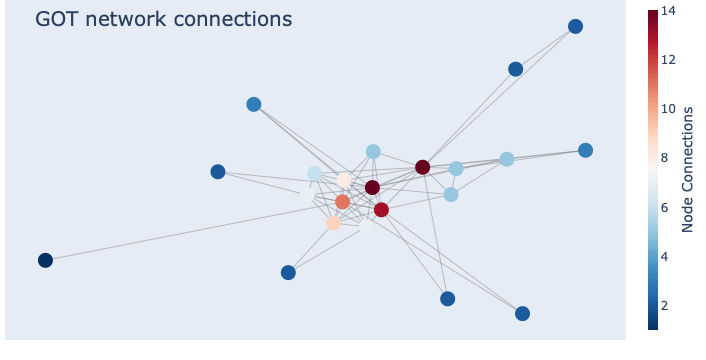

In [60]:
draw_plotly_network_graph(Graph_obj = G, filter = None, filter_nodesbydegree = None)


**Observation:**

- **Hamlet** is the most connected character across the book series, followed by Jon Snow and Jamie Lannister.

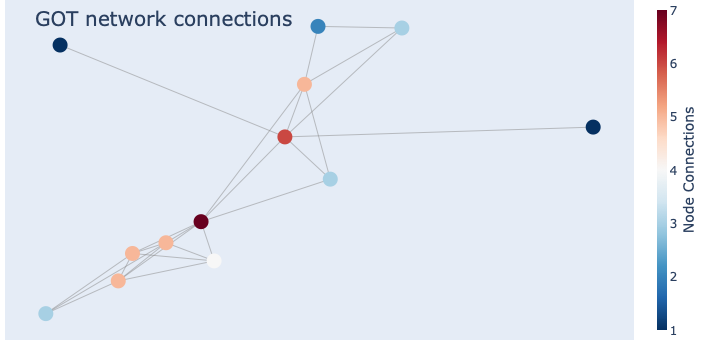

In [62]:
draw_plotly_network_graph(Graph_obj = G1, filter = "Yes", filter_nodesbydegree = 50) #Top 50 characters network in Book 1

#### **Summary - Act I.**

1. **Hamlet** is the most connected character, followed by **King**. 
2. Pol., Hor., and Mar. are in the top 5 characters.



In [63]:
deg_central(G1)[:5]

,Character,Degree Centrality
0,Ham.,0.58
1,King.,0.50
2,Pol.,0.42
3,Mar.,0.42
4,Hor.,0.42


### **ACT.II**

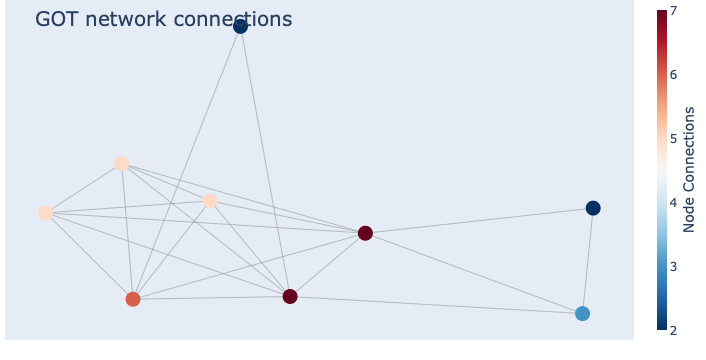

In [64]:
draw_plotly_network_graph(Graph_obj = G2, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary -Act.II**
1. **King** has become the central character, followed by **Pol** and **Queen**. 


In [67]:
deg_central(G2)[:5]

,Character,Degree Centrality
0,King.,0.88
1,Pol.,0.88
2,Queen.,0.75
3,Ros.,0.62
4,Guil.,0.62


### **ACT.III**

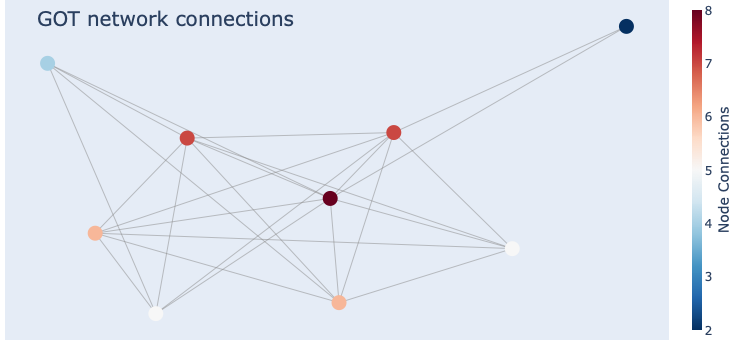

In [68]:
draw_plotly_network_graph(Graph_obj = G3, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Act.III**
1. **Hamlet** remains the most central character, followed by **King** & **Queen**. 

In [69]:
deg_central(G3)[:5]

,Character,Degree Centrality
0,Ham.,1.00
1,King.,0.88
2,Queen.,0.88
3,Pol.,0.75
4,Ros.,0.75


### **ACT.IV**

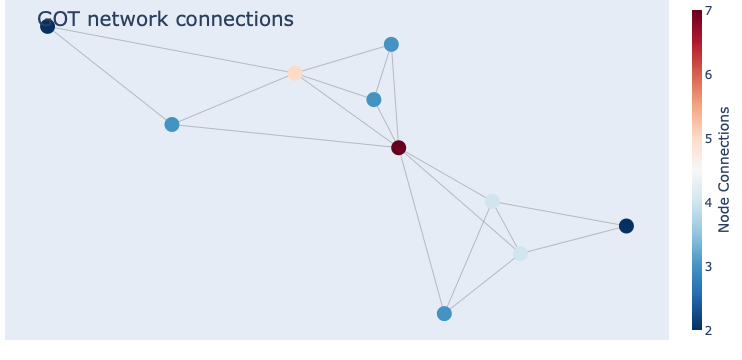

In [72]:
draw_plotly_network_graph(Graph_obj = G4, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Act.IV**
1. **Hamlet** does not remain the most central character, 
2. **King** gains the importance followed by **Queen**. 
3. **Oph** and her brother,**Laertes**, gains their importance .

In [74]:
deg_central(G4)[:5]

,Character,Degree Centrality
0,King.,0.78
1,Queen.,0.56
2,Ham.,0.44
3,Ros.,0.44
4,Hor.,0.33


### **ACT. V.**

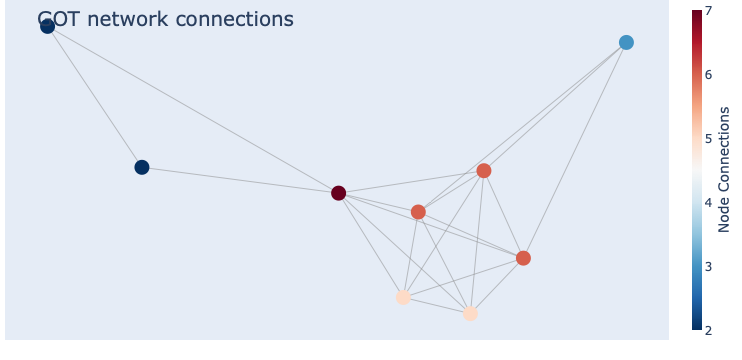

In [76]:
draw_plotly_network_graph(Graph_obj = G5, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Act. V**
1. **Hamlet** remains the most central character, 
2. **Queen** gains the importance followed by **Laertes**. 

In [78]:
betweenness_central(G5)[:5]

,Character,Betweenness Centrality
0,Hor.,0.64
1,Queen.,0.43
2,Priest.,0.25
3,Ambassador.,0.12
4,King.,0.00


In [79]:
deg_central(G5)[:5]

,Character,Degree Centrality
0,Hor.,0.88
1,Ham.,0.75
2,Laer.,0.75
3,Queen.,0.75
4,King.,0.62


## **Evolution of central characters through the books**

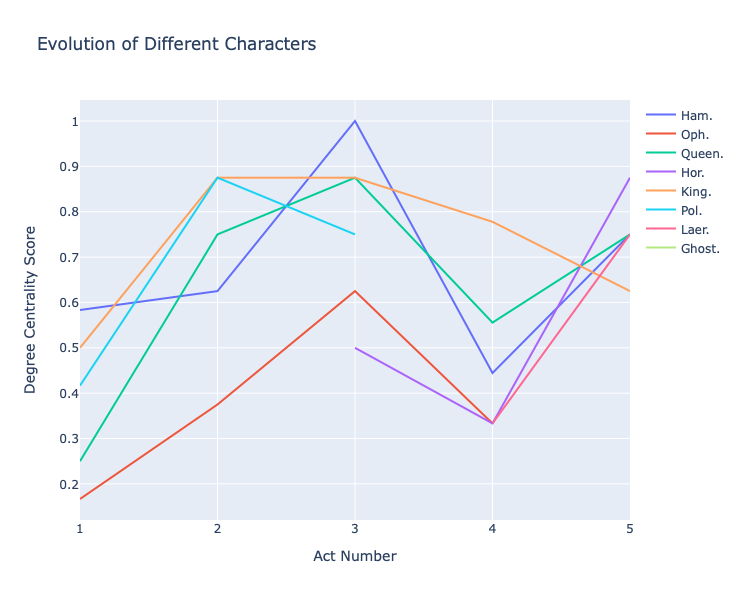

In [85]:
# Creating a list of degree centrality of all the books
Acts_Graph = [G1, G2, G3, G4, G5]

evol = [nx.degree_centrality(Graph) for Graph in Acts_Graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

degree_evol_df.index = degree_evol_df.index + 1

# Plotting the degree centrality evolution of few important characters
fig = px.line(degree_evol_df[['Ham.', 'Oph.', 'Queen.', 'Hor.', 'King.', 'Pol.', 'Laer.',"Ghost."]],
             title = "Evolution of Different Characters", width = 900, height = 600)

fig.update_layout(xaxis_title = 'Act Number',
                   yaxis_title = 'Degree Centrality Score',
                 legend = {'title_text': ''})

fig.show()

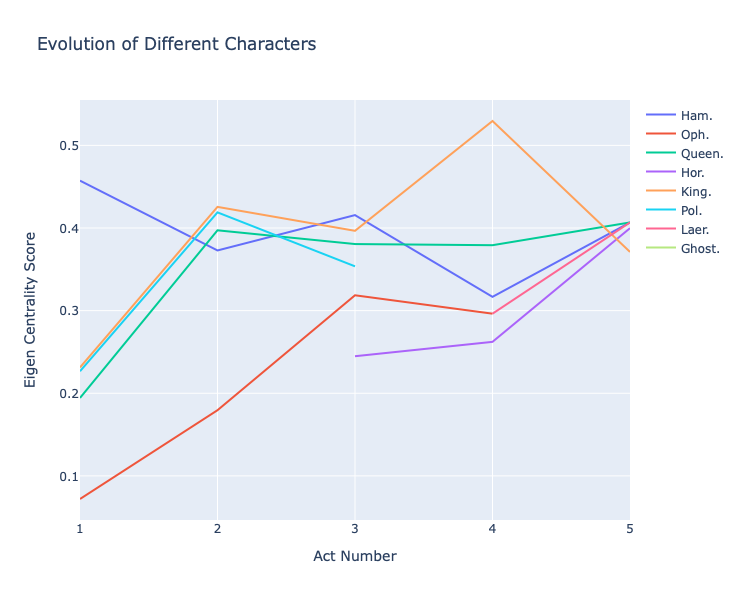

In [84]:
# Creating a list of degree centrality of all the books
Acts_Graph = [G1, G2, G3, G4, G5]

evol = [nx.eigenvector_centrality(Graph) for Graph in Acts_Graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

degree_evol_df.index = degree_evol_df.index + 1

# Plotting the degree centrality evolution of few important characters
fig = px.line(degree_evol_df[['Ham.', 'Oph.', 'Queen.', 'Hor.', 'King.', 'Pol.', 'Laer.',"Ghost."]],
             title = "Evolution of Different Characters", width = 900, height = 600)

fig.update_layout(xaxis_title = 'Act Number',
                   yaxis_title = 'Eigen Centrality Score',
                 legend = {'title_text': ''})

fig.show()

## **Community Detection**

In [87]:
import community as community_louvain
import matplotlib.cm as cm
import colorlover as cl

A Network has community structure if its nodes can be easily grouped into (potentially overlapping) sets of nodes, with each set of nodes being densely connected internally. There are numerous algorithms and definitions for calculating these networks' communities.

To find the modules in our graph, we will use the Louvain method.

The Louvain Community Detection Algorithm is a straightforward method for determining a network's community structure. It is a heuristic method for optimising modularity.

The algorithm operates in two steps. In the first step, each node is assigned to its own community, and then for each node, it attempts to maximise positive modularity gain by moving each node to all of its neighbour communities. If no positive gain is obtained, the node is returned to its original community.

In [89]:
# compute the best partition
partition = community_louvain.best_partition(G, random_state = 12345)

partition_df = pd.DataFrame([partition]).T.reset_index()

partition_df.columns = ["Character", "Community"]

partition_df

,Character,Community
0,Hor.,1
1,Ambassador.,1
2,Fran.,1
3,Ber.,1
4,Ghost.,1
5,Ham.,2
6,Mar.,1
7,Capt.,2
8,Ros.,2
9,King.,0


### **Let's look at the distribution of communities** 

In [90]:
partition_df["Community"].value_counts().sort_values(ascending = False)

0    10
1     7
2     5
Name: Community, dtype: int64

### **The Louvain community library returns Cluster IDs, we have turned them into colors using the Colorlover library**


In [91]:
colors = cl.scales['12']['qual']['Paired']

def scatter_nodes(G, pos, labels = None, color = 'rgb(152, 0, 0)', size = 8, opacity = 1):
    # pos is the dictionary of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None, the Plotly's default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between 0 and 1, defining the node color opacity

    trace = go.Scatter(x = [], 
                    y = [],  
                    text = [],   
                    mode = 'markers', 
                    hoverinfo = 'text',
                           marker = dict(
            showscale = False,
            colorscale = 'RdBu',
            reversescale = True,
            color = [],
            size = 15,
            colorbar = dict(
                thickness = 10,
                xanchor = 'left',
                titleside = 'right'
            ),
            line = dict(width = 0)))
    
    for nd in G.nodes():
        x, y = G.nodes[nd]['pos']
        
        trace['x'] += tuple([x])
        
        trace['y'] += tuple([y])
        
        color = colors[partition[nd] % len(colors)]
        
        trace['marker']['color'] += tuple([color])
        
    for node, adjacencies in enumerate(G.adjacency()):
        node_info = adjacencies[0]
        
        trace['text'] += tuple([node_info])

    return trace    

def scatter_edges(G, pos, line_color = '#a3a3c2', line_width = 1, opacity = .2):
    trace = go.Scatter(x = [], 
                    y = [], 
                    mode = 'lines'
                   )
    
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        
        x1, y1 = G.nodes[edge[1]]['pos']
        
        trace['x'] += tuple([x0, x1, None])
        
        trace['y'] += tuple([y0, y1, None])
        
        trace['hoverinfo'] = 'none'
        
        trace['line']['width'] = line_width
        
        if line_color is not None:                 # when line_color is None, a default Plotly color is used
            trace['line']['color'] = line_color
    
    return trace

In [92]:
def visualize_community(Graph, filter = "Yes", filter_nodes = 100):
    G_dup = G.copy()

    degrees = nx.classes.degree(G_dup)
    
    degree_df = pd.DataFrame(degrees)
    
    if filter is not None:
        top = deg_centrality_sort[:filter_nodes]["Character"].values
        
        G_dup.remove_nodes_from([node
                             for node in G_dup.nodes
                             if node not in top
                            ])

    pos = nx.spring_layout(G_dup, seed = 1234567)

    for n, p in pos.items():
        G_dup.nodes[n]['pos'] = p

    trace1 = scatter_edges(G_dup, pos, line_width = 0.25)
    trace2 = scatter_nodes(G_dup, pos)
    
    fig = go.Figure(data = [trace1, trace2],
             layout = go.Layout(
                title = '<br> GOT Community Detection',
                titlefont = dict(size = 20),
                showlegend = False,
                hovermode = 'closest',
                margin = dict(b = 20, l = 5, r = 5, t = 40),
                annotations = [ dict(
                    text = "",
                    showarrow = False,
                    xref = "paper", yref = "paper") ],
                xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))
    
    iplot(fig)

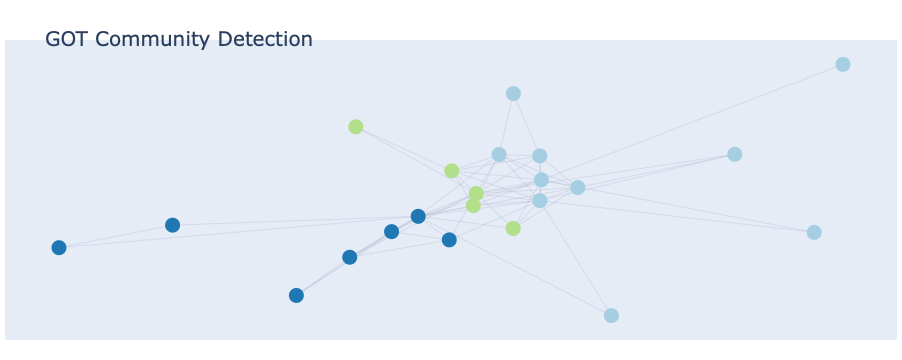

In [93]:
visualize_community(Graph = G, filter = "Yes", filter_nodes = 100)

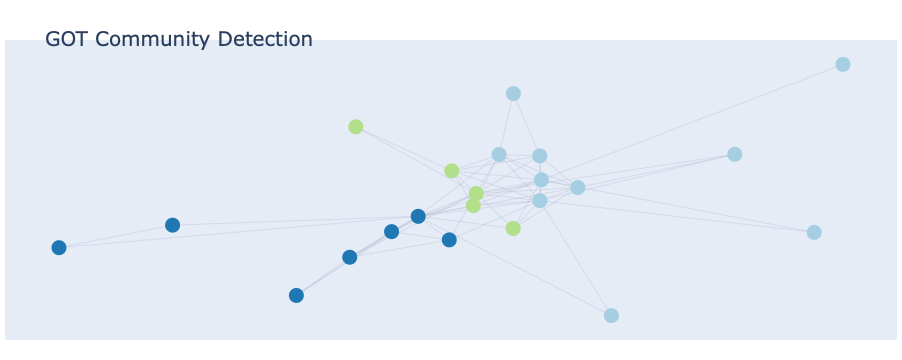

In [96]:
visualize_community(Graph = G1, filter = "Yes", filter_nodes = 100)